In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    recall_score, f1_score, roc_auc_score,
    accuracy_score, precision_score,
    roc_curve, precision_recall_curve, auc,
    ConfusionMatrixDisplay, confusion_matrix,
    mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier


C:\Users\ashle\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load data for Ashley
data = pd.read_csv("C:/Users/ashle/OneDrive/Documents/Courses/UNC Courses/665 - Applied Stat II/2025_NBA_Project/nba_playoffdata_combined.csv")
data.shape

(656, 56)

In [3]:
# Save team name columns
winners = data['Winner'].copy()
losers = data['Loser'].copy()

# Drop unnecessary columns
data.drop(columns=['Winner', 'Loser', 'Winner Team', 'Loser Team'], inplace=True)

# Create net win column (response var)
def compute_net_wins(row):
    win_diff = row['Winner Games Won'] - row['Loser Games Won']

    if row['Winner Seed'] < row['Loser Seed']:
        return win_diff
    else:  
        return -win_diff

data['Net Wins'] = data.apply(compute_net_wins, axis=1)

# Drop columns that make 'Net Wins' dependent
data.drop(columns=['Winner Games Won', "Loser Games Won"], inplace=True)

In [5]:
# Create dummy variables for categorical
data = pd.get_dummies(data, drop_first=True)

# Standardize numerical variables?

In [6]:
# Check data
data.head()

Year  Winner Seed  Loser Seed  Winner Rk  Winner MP  Winner FG  Winner FGA  \
0  2024            1           8          2      241.8       43.9        90.2   
1  2024            4           5         20      241.5       41.8        87.2   
2  2024            6           3          1      240.3       47.0        92.7   
3  2024            2           7         19      240.6       41.3        88.7   
4  2024            1           8          3      241.5       44.5        89.3   

   Winner FG%  Winner 3P  Winner 3PA  ...  Loser TOV  Loser PF  Loser PTS  \
0       0.487       16.5        42.5  ...       12.7      17.3      110.1   
1       0.479       13.5        36.8  ...       14.7      19.7      110.5   
2       0.507       13.2        35.3  ...       12.9      19.2      119.0   
3       0.465       13.2        35.8  ...       12.0      20.3      114.6   
4       0.499       13.3        34.2  ...       13.0      18.4      115.1   

   Net Wins  Round_Eastern Conf First Round  Round_Eastern Conf Semifinals  \
0         3                            True                          False   
1         1                            True                          False   
2        -2                            True                          False   
3         2                            True                          False   
4         4                           False                          False   

   Round_Finals  Round_Western Conf Finals  Round_Western Conf First Round  \
0         False                      False                           False   
1         False                      False                           False   
2         False                      False                           False   
3         False                      False                           False   
4         False                      False                            True   

   Round_Western Conf Semifinals  
0                          False  
1                          False  
2                          False  
3                          False  
4                          False  

[5 rows x 56 columns]

In [7]:
# Train-test split
X = data.drop('Net Wins', axis=1)
y = data['Net Wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=665)

print(X_train.shape)
print(X_test.shape)

(459, 55)
(197, 55)


In [14]:
# Grid search to find best model
rf = RandomForestClassifier(random_state=665)
grid = {'n_estimators': [50, 100, 200, 500],     # num of trees
        'max_features': [5, 'sqrt', 15, 30]}   # num of predictors at each split

tune_rf = GridSearchCV(rf, grid, cv=5, scoring='accuracy', verbose=2)
tune_rf.fit(X_train, y_train)

# Get best model
rf_model = tune_rf.best_estimator_
rf_best_param = tune_rf.best_params_
print("Best parameters:", rf_best_param)

# Make predictions
rf_preds = rf_model.predict(X_test)

# Calculate MSE
rf_mse = mean_squared_error(y_test, rf_preds)
print("Random Forest MSE:", rf_mse)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END ....................max_features=5, n_estimators=50; total time=   0.1s
[CV] END ....................max_features=5, n_estimators=50; total time=   0.2s
[CV] END ....................max_features=5, n_estimators=50; total time=   0.1s
[CV] END ....................max_features=5, n_estimators=50; total time=   0.1s
[CV] END ....................max_features=5, n_estimators=50; total time=   0.1s
[CV] END ...................max_features=5, n_estimators=100; total time=   0.3s
[CV] END ...................max_features=5, n_estimators=100; total time=   0.3s
[CV] END ...................max_features=5, n_estimators=100; total time=   0.2s
[CV] END ...................max_features=5, n_estimators=100; total time=   0.3s
[CV] END ...................max_features=5, n_estimators=100; total time=   0.2s
[CV] END ...................max_features=5, n_estimators=200; total time=   0.5s
[CV] END ...................max_features=5, n_es

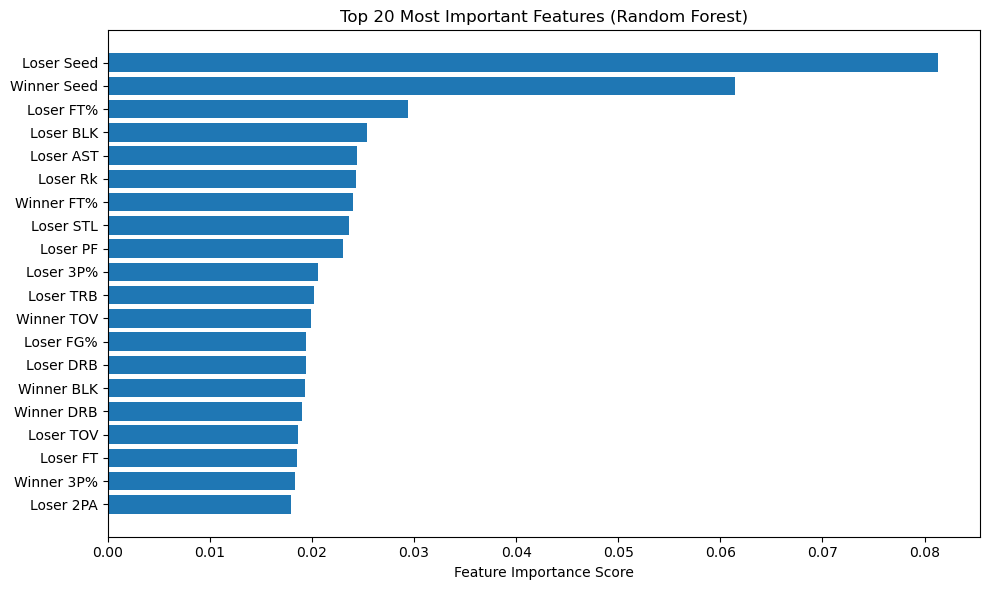

In [16]:
# Feature importance for Random Forest
feature_names = X_train.columns
rf_importances = rf_model.feature_importances_
sorted_idx = np.argsort(rf_importances)[::-1][:20]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_idx)), rf_importances[sorted_idx][::-1], align='center')
plt.yticks(range(len(sorted_idx)), feature_names[sorted_idx][::-1])
plt.xlabel('Feature Importance Score')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()